In [2]:
import warnings
warnings.filterwarnings('ignore')

import koreanize_matplotlib

In [21]:
import pandas as pd

train = pd.read_csv('Data/train_0820.csv')

In [4]:
import numpy as  np
print(np.__version__)


2.2.0


In [6]:
"""
DTW-KMeans clustering with:
1) Closed-world building load-profile extraction (weekday/weekend 24h → 48 dims)
2) Elbow method (DTW inertia) over a K range + plot
3) Cluster fitting at chosen K, centroid (DBA barycenter) visualizations
4) Optional 2D PCA scatter of 48-d profiles colored by cluster
5) Save mapping: building → cluster_id

Requirements: tslearn, scikit-learn, matplotlib, pandas, numpy

Adjust PATHS and PARAMS section as needed.
"""

# ====== PARAMS ======
VALUE_COL  = "전력소비량(kWh)"              # target/series column
TIME_COL   = "일시"                        # timestamp column
BID_COL    = "건물번호"                     # building id column

K_CANDIDATES = [6,8,10,12,15,20,25]       # range for elbow search
CHOSEN_K     = 15                            # set after inspecting elbow plot

SAVE_PREFIX  = "dtw_kmeans"                 # output file prefix
MAP_CSV_PATH = f"{SAVE_PREFIX}_building_cluster_map.csv"

RANDOM_STATE = 42

# ====== IMPORTS ======
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

# ====== UTILS ======

def build_weekday_weekend_48d_profile(df: pd.DataFrame,
                                      value_col: str = VALUE_COL,
                                      time_col: str = TIME_COL,
                                      bid_col: str = BID_COL):
    """Return (bnums, X48) where X48 is (n_buildings, 48) weekday(0..23)+weekend(0..23).
       Missing hours are filled with 0. Assumes df has full history for averaging.
    """
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
    d["hour"] = d[time_col].dt.hour
    d["is_weekend"] = (d[time_col].dt.weekday >= 5).astype(int)

    # mean by building × weekend flag × hour
    g = (
        d.groupby([bid_col, "is_weekend", "hour"], observed=True)[value_col]
         .mean()
         .unstack([1, 0])  # columns: MultiIndex (is_weekend, building)
    )
    bnums = sorted(d[bid_col].unique())

    mats = []
    for b in bnums:
        # weekday
        if (0, b) in g.columns:
            wkd = g[(0, b)].reindex(range(24)).fillna(0.0).values
        else:
            wkd = np.zeros(24)
        # weekend
        if (1, b) in g.columns:
            wke = g[(1, b)].reindex(range(24)).fillna(0.0).values
        else:
            wke = np.zeros(24)
        mats.append(np.r_[wkd, wke])

    X48 = np.vstack(mats)
    return bnums, X48


def compute_dtw_inertias(X48: np.ndarray, k_list, random_state=RANDOM_STATE,
                          n_init=5, max_iter_barycenter=50):
    """Compute DTW-KMeans inertia for each K. Returns dict K->inertia and tslearn-ready data.
    """
    # scale (z-score) to remove scale effect across buildings
    scaler = StandardScaler()
    X48z = scaler.fit_transform(X48)

    # reshape to time-series dataset: (n_samples, time_length)
    X_ts = to_time_series_dataset(X48z.reshape(-1, X48z.shape[1]))

    inertias = {}
    for k in k_list:
        km = TimeSeriesKMeans(
            n_clusters=k,
            metric="dtw",
            n_init=n_init,
            max_iter_barycenter=max_iter_barycenter,
            random_state=random_state,
        )
        labels = km.fit_predict(X_ts)
        inertias[k] = km.inertia_
        print(f"K={k:>2}  inertia={km.inertia_:.4f}")
    return inertias, scaler, X_ts


def plot_elbow(inertias: dict, title="DTW-KMeans Elbow (Inertia vs K)"):
    ks = sorted(inertias.keys())
    vals = [inertias[k] for k in ks]
    plt.figure(figsize=(6,4))
    plt.plot(ks, vals, marker="o")
    plt.xlabel("K (number of clusters)")
    plt.ylabel("DTW inertia (lower is better)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def fit_clusters_and_visualize(bnums, X48, scaler, X_ts, K=CHOSEN_K,
                               random_state=RANDOM_STATE, n_init=5,
                               max_iter_barycenter=50, save_prefix=SAVE_PREFIX,
                               map_csv_path=MAP_CSV_PATH):
    """Fit DTW-KMeans at chosen K, plot centroids (DBA), PCA scatter, and save mapping CSV."""
    km = TimeSeriesKMeans(
        n_clusters=K,
        metric="dtw",
        n_init=n_init,
        max_iter_barycenter=max_iter_barycenter,
        random_state=random_state,
    )
    labels = km.fit_predict(X_ts)
    print(f"Fitted DTW-KMeans with K={K}. Inertia={km.inertia_:.4f}")

    # ---- Save mapping ----
    mapping_df = pd.DataFrame({"건물번호": bnums, "cluster_id": labels})
    mapping_df.to_csv(map_csv_path, index=False)
    print(f"Saved building→cluster map to: {map_csv_path}")

    # ---- Plot cluster centroids (DBA barycenters) ----
    # barycenters shape: (K, time_length)
    bary = km.cluster_centers_.squeeze()  # (K, 48)

    # revert scaler to original scale (optional, for interpretability)
    # Because centroids live in scaled space, inverse_transform per time index:
    # We can inverse by building a dummy array and applying scaler.inverse_transform.
    bary_inv = scaler.inverse_transform(bary)

    hours = np.arange(24)
    plt.figure(figsize=(10, 6))
    for cid in range(K):
        # split weekday/weekend 24h
        wkd = bary_inv[cid, :24]
        wke = bary_inv[cid, 24:]
        plt.plot(hours, wkd, alpha=0.9, label=f"C{cid} Weekday")
        plt.plot(hours, wke, alpha=0.9, linestyle="--", label=f"C{cid} Weekend")
    plt.xlabel("Hour of day")
    plt.ylabel(VALUE_COL)
    plt.title("Cluster DBA Barycenters (Weekday solid / Weekend dashed)")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---- PCA scatter for 48-d profiles ----
    X48z = scaler.transform(X48)
    pca = PCA(n_components=2, random_state=random_state)
    X2 = pca.fit_transform(X48z)

    plt.figure(figsize=(6,5))
    for cid in range(K):
        idx = (labels == cid)
        plt.scatter(X2[idx, 0], X2[idx, 1], s=20, alpha=0.8, label=f"C{cid}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA(48d) scatter by cluster")
    plt.legend(ncol=2, fontsize=8)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # ---- Cluster sizes bar ----
    sizes = pd.Series(labels).value_counts().sort_index()
    ax = sizes.plot(kind="bar", rot=0)
    ax.set_xlabel("cluster_id")
    ax.set_ylabel("#buildings")
    ax.set_title("Cluster sizes")
    plt.tight_layout()
    plt.show()

    return mapping_df, km




K= 6  inertia=1.2471
K= 8  inertia=0.8921
K=10  inertia=0.5806
K=12  inertia=0.3845
K=15  inertia=0.2571
K=20  inertia=0.1502
K=25  inertia=0.1026


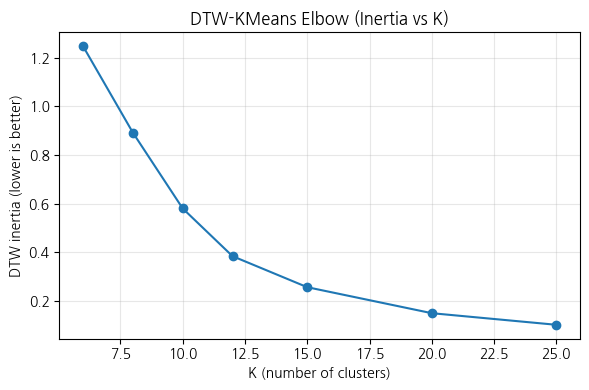

Fitted DTW-KMeans with K=15. Inertia=0.2571
Saved building→cluster map to: dtw_kmeans_building_cluster_map.csv


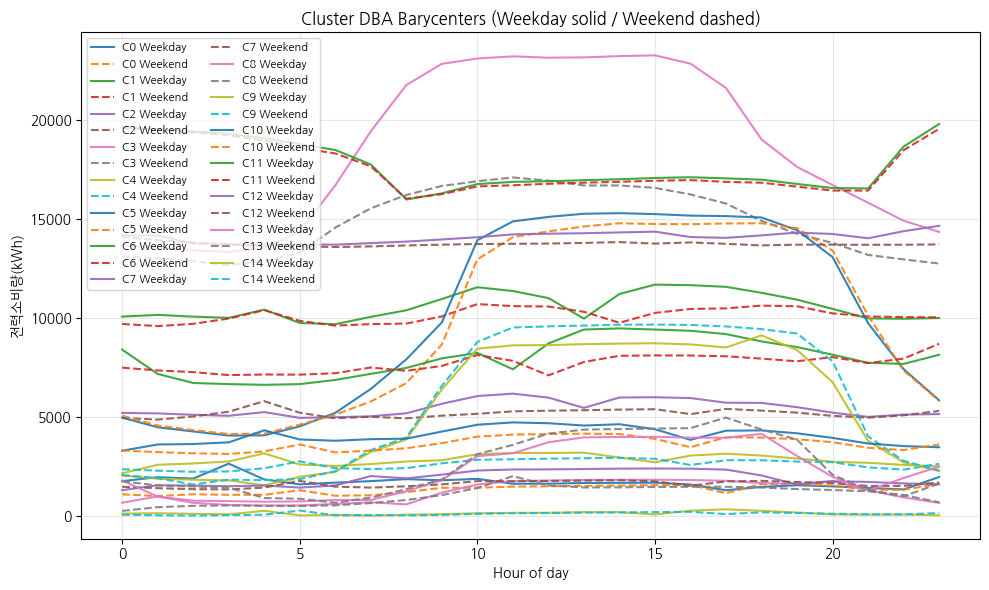

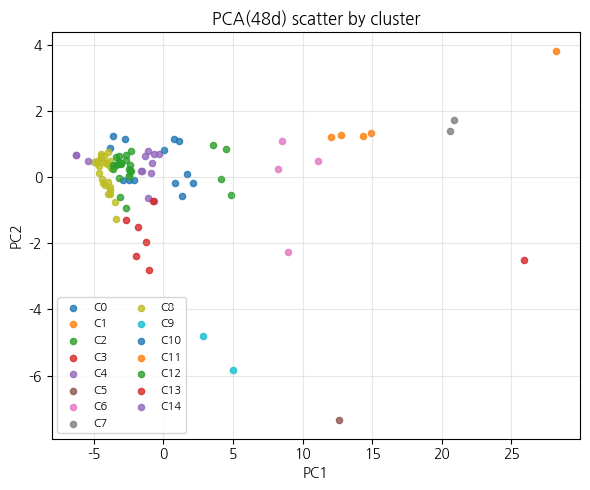

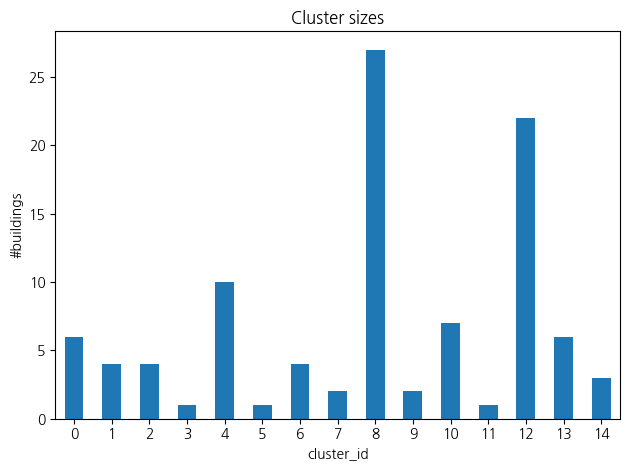

In [9]:
# ====== MAIN ======
if __name__ == "__main__":
    # 1) Load train & build profiles
    train = pd.read_csv("Data/train_0820.csv")
    bnums, X48 = build_weekday_weekend_48d_profile(train, VALUE_COL, TIME_COL, BID_COL)

    # 2) Elbow search
    inertias, scaler, X_ts = compute_dtw_inertias(X48, K_CANDIDATES)
    plot_elbow(inertias)

    # 3) Fit at chosen K and visualize (edit CHOSEN_K after checking elbow)
    _map, _km = fit_clusters_and_visualize(bnums, X48, scaler, X_ts,
                                           K=CHOSEN_K,
                                           save_prefix=SAVE_PREFIX,
                                           map_csv_path=MAP_CSV_PATH)

In [22]:
if __name__ == "__main__":
    # 선택된 군집만 실행
    bnums, X48 = build_weekday_weekend_48d_profile(train, VALUE_COL, TIME_COL, BID_COL)

    # 2) Scale -> tslearn dataset
    scaler = StandardScaler()
    X48z = scaler.fit_transform(X48)                # (n_buildings, 48)
    X_ts  = to_time_series_dataset(X48z)           # (n_buildings, 48) for tslearn

    # 3) Fit DTW-KMeans at K=15 ONLY (no elbow, no plots)
    K_FINAL = 12
    km = TimeSeriesKMeans(
        n_clusters=K_FINAL,
        metric="dtw",
        n_init=10,
        max_iter_barycenter=100,
        random_state=RANDOM_STATE,
    )
    labels = km.fit_predict(X_ts)
    print(f"[INFO] Fitted DTW-KMeans with K={K_FINAL}. Inertia={km.inertia_:.4f}")

    # 4) Save mapping only
    mapping_df = pd.DataFrame({"건물번호": bnums, "cluster_id": labels})
    mapping_df.to_csv(MAP_CSV_PATH, index=False, encoding="utf-8-sig")
    print(f"[SAVED] building→cluster map -> {MAP_CSV_PATH}")

[INFO] Fitted DTW-KMeans with K=12. Inertia=0.3633
[SAVED] building→cluster map -> dtw_kmeans_building_cluster_map.csv


## 일단 DTW 시도
SMAPE가 최소가 되는 K 12로 설정
soft=DTW도 돌려서 비교  


In [8]:
train['건물유형'].value_counts()

건물유형
백화점         32640
호텔          20400
상용          20400
학교          20400
건물기타        20400
병원          18360
아파트         18360
연구소         18360
IDC(전화국)    18360
공공          16320
Name: count, dtype: int64

In [23]:
train = pd.read_csv("Data/train_0820.csv")
train["건물번호"] = train["건물번호"].astype(mapping_df["건물번호"].dtype)
train_with_cluster = train.merge(mapping_df, on="건물번호", how="left")

# 안전 체크
assert train_with_cluster["cluster_id"].notna().all(), "cluster_id가 비어있는 건물이 있습니다."
train_with_cluster['기온_MA3'] = train_with_cluster.groupby("건물번호")['기온(°C)'].transform(lambda x: x.rolling(3, min_periods=1).mean())

# 저장
train_with_cluster.to_csv("Data/train_0821withcluster.csv", index=False, encoding="utf-8-sig")
print("붙이기 완료 → train_with_cluster.csv")

test = pd.read_csv("Data/test_0820.csv")
test["건물번호"] = test["건물번호"].astype(mapping_df["건물번호"].dtype)
test_with_cluster = test.merge(mapping_df, on="건물번호", how="left")
assert test_with_cluster["cluster_id"].notna().all()
test_with_cluster['기온_MA3'] = test_with_cluster.groupby("건물번호")['기온(°C)'].transform(lambda x: x.rolling(3, min_periods=1).mean())

test_with_cluster.to_csv("Data/test_0821withcluster.csv", index=False, encoding="utf-8-sig")


붙이기 완료 → train_with_cluster.csv


In [11]:
train_with_cluster.columns, test_with_cluster.columns

(Index(['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
        '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)', '건물유형', '연면적(m2)', '냉방면적(m2)',
        '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)', 'month', 'day', 'hour',
        'weekday', 'is_weekend', 'holiday', 'cdh_base_used', 'DI', 'THI', 'CDH',
        'cool_area_ratio', 'kWh_per_m2', 'ess_hours', 'is_peak_hour',
        'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'is_rain', 'T_x_RH',
        'T2', 'RH2', 'T_x_rain', 'wind_level', 'cooling_load_index',
        'btype_IDC(전화국)', 'btype_건물기타', 'btype_공공', 'btype_백화점', 'btype_병원',
        'btype_상용', 'btype_아파트', 'btype_연구소', 'btype_학교', 'btype_호텔',
        'time_usage_level', 'day_usage_level', 'cluster_id'],
       dtype='object'),
 Index(['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
        '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)',
        'month', 'day', 'hour', 'weekday', 'is_weekend', 'holiday',
        '

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer
import xgboost as xgb

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return 200.0 * np.mean(np.abs(y_pred - y_true) / denom)

# sklearn용: 낮을수록 좋은 지표 → 음수로 바꿔서 최대화하도록
smape_scorer = make_scorer(lambda yt, yp: -smape(yt, yp), greater_is_better=True)

def coerce_numeric_objects(df, exclude=()):
    """object 중 숫자문자열을 float로 변환. '-', '', None -> 0"""
    out = df.copy()
    obj_cols = out.select_dtypes(include=['object']).columns
    for c in obj_cols:
        if c in exclude: 
            continue
        out[c] = (
            out[c]
            .replace({"-": "0", "": "0", None: "0"})
            .astype(str)
            .str.replace(",", "", regex=False)
        )
        out[c] = pd.to_numeric(out[c], errors="coerce").fillna(0.0)
    return out


In [13]:
# 경로는 네 환경에 맞춰 수정
TRAIN_PATH = "Data/train_0821withcluster.csv"
TEST_PATH  = "Data/test_0821withcluster.csv"   # 테스트에도 동일한 파생변수 컬럼이 있다고 가정

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)
train

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh),...,btype_백화점,btype_병원,btype_상용,btype_아파트,btype_연구소,btype_학교,btype_호텔,time_usage_level,day_usage_level,cluster_id
0,1_20240601 00,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.00,5794.80,...,False,False,False,False,False,False,True,0,1,2
1,1_20240601 01,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.00,5591.85,...,False,False,False,False,False,False,True,0,1,2
2,1_20240601 02,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.00,5338.17,...,False,False,False,False,False,False,True,0,1,2
3,1_20240601 03,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.00,4554.42,...,False,False,False,False,False,False,True,-1,1,2
4,1_20240601 04,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.00,3602.25,...,False,False,False,False,False,False,True,-1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20240824 19,100,2024-08-24 19:00:00,29.1,0.0,4.4,76.0,0.4,0.18,3276.00,...,False,False,False,False,False,False,True,0,1,0
203996,100_20240824 20,100,2024-08-24 20:00:00,28.6,0.0,3.7,74.0,0.0,0.00,3197.52,...,False,False,False,False,False,False,True,0,1,0
203997,100_20240824 21,100,2024-08-24 21:00:00,28.3,0.0,2.9,74.0,0.0,0.00,3006.60,...,False,False,False,False,False,False,True,0,1,0
203998,100_20240824 22,100,2024-08-24 22:00:00,28.0,0.0,1.7,76.0,0.0,0.00,2649.72,...,False,False,False,False,False,False,True,1,1,0


In [14]:
from collections import defaultdict

TARGET = "전력소비량(kWh)"
BASE_DROP = ["num_date_time", "일시", "건물유형",'일조(hr)', '일사(MJ/m2)', TARGET]   # 필요 없는/오브젝트 문제 유발 컬럼 제거
val_scores = {}
models = {}
preds_list = []

building_clusters = sorted(train["cluster_id"].unique())
print("clusters:", building_clusters)

for cid in building_clusters:
    train_sub = train[train["cluster_id"] == cid].copy()
    test_sub  = test[test["cluster_id"] == cid].copy()
    if len(train_sub) == 0:
        continue

    # Feature / Target
    drop_cols = BASE_DROP + ["cluster_id"]
    X_all = train_sub.drop(columns=[c for c in drop_cols if c in train_sub.columns], errors="ignore")
    y_all = train_sub[TARGET]

    X_all = coerce_numeric_objects(X_all)

    # Train / Validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=0.2, random_state=38
    )

    # --- 모델 학습 ---

    xgb_model = xgb.XGBRegressor(
        n_estimators=700,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",   # GPU 사용 시 "gpu_hist"
        random_state=42,
        n_jobs=-1,
        eval_metric="mae"
    )
        
    model = xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Validation 성능 기록
    y_val_pred = np.clip(model.predict(X_val), 0, None)
    val_scores[cid] = smape(y_val, y_val_pred)

    # 모델 저장
    models[cid] = model

    # Test 예측
    X_test = test_sub.drop(columns=[c for c in BASE_DROP + ["cluster_id"] if c in test_sub.columns], errors="ignore")
    X_test = coerce_numeric_objects(X_test)
    test_sub["pred"] = np.clip(model.predict(X_test), 0, None)

    preds_list.append(test_sub[["num_date_time", "건물번호", "pred"]])


clusters: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11)]


In [15]:
# 결과 합치기
final_preds = pd.concat(preds_list, ignore_index=True).sort_values(by=["num_date_time", "건물번호"])
print("검증 SMAPE(군집별):", val_scores)
print("평균(가중X) SMAPE:", np.mean(list(val_scores.values())))

검증 SMAPE(군집별): {np.int64(0): np.float64(4.746783565708655), np.int64(1): np.float64(0.8206046839610723), np.int64(2): np.float64(2.7360393937026792), np.int64(3): np.float64(1.0167319554984682), np.int64(4): np.float64(2.566229959507663), np.int64(5): np.float64(4.370613570448635), np.int64(6): np.float64(0.6976789355109182), np.int64(7): np.float64(2.3696056800884087), np.int64(8): np.float64(2.6736239890529623), np.int64(9): np.float64(2.2905158568858357), np.int64(10): np.float64(4.949284364106213), np.int64(11): np.float64(5.418916994401124)}
평균(가중X) SMAPE: 2.888052412406053


In [32]:
submit =  pd.read_csv('Data/sample_submission.csv')
submit_final = (
    submit
    .merge(final_preds, on=['num_date_time'], how='left')
    .drop(columns=['answer','건물번호'], axis = 1)                          # 기존 answer 버리고
    .rename(columns={'pred': 'answer'})                # pred → answer 로 변경
)
submit_final.to_csv(f'Submit/submit0821_cluster_{np.mean(list(val_scores.values()))}.csv',index = False)
submit_final

,num_date_time,answer
0,1_20240825 00,4405.358887
1,1_20240825 01,4305.764160
2,1_20240825 02,4046.869385
3,1_20240825 03,3028.819580
4,1_20240825 04,3068.691162
...,...,...
16795,100_20240831 19,2526.431152
16796,100_20240831 20,2504.365479
16797,100_20240831 21,2430.251709
16798,100_20240831 22,2634.223633


## 피쳐임포턴스


=== 건물유형: 0 ===
             feature   importance
37         btype_백화점  7442534.000
44  time_usage_level  7211742.500
40         btype_아파트  6214346.000
26         month_cos  5421398.500
20   cool_area_ratio  1857483.875
45   day_usage_level  1808224.375
39          btype_상용  1787003.250
7          태양광용량(kW)  1628878.250
10             month  1319333.375
5            연면적(m2)  1167252.250


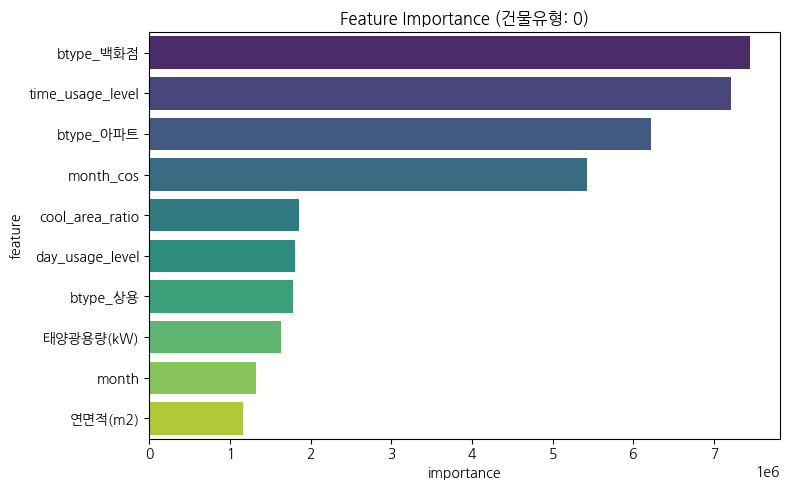


=== 건물유형: 1 ===
            feature    importance
5           연면적(m2)  1.720878e+06
0              건물번호  1.450995e+06
23        month_cos  6.855222e+05
18  cool_area_ratio  5.484253e+05
8             month  5.237646e+05
6          냉방면적(m2)  4.410876e+05
32  day_usage_level  3.677046e+05
22        month_sin  3.458620e+05
9               day  2.092127e+05
12       is_weekend  2.081390e+05


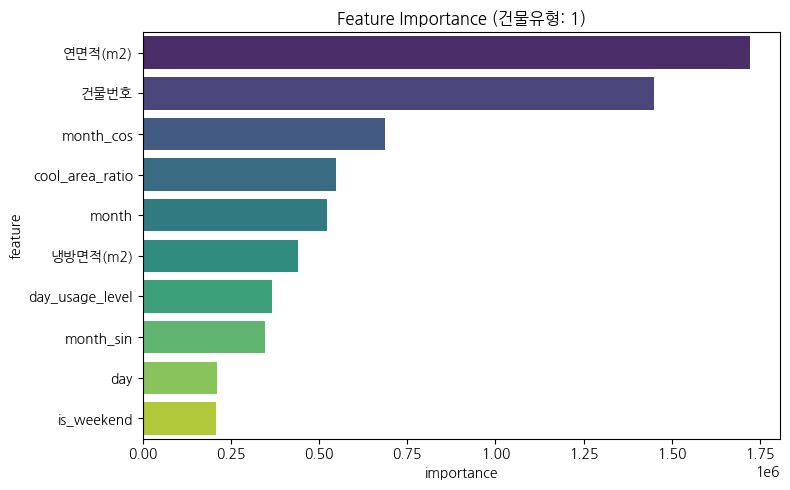


=== 건물유형: 2 ===
             feature    importance
5            연면적(m2)  7.375991e+06
6           냉방면적(m2)  4.523902e+06
7          태양광용량(kW)  3.627428e+06
12        is_weekend  1.381162e+06
13           holiday  9.610502e+05
34  time_usage_level  8.745261e+05
11           weekday  5.879162e+05
26                T2  5.533294e+05
21          hour_cos  4.806363e+05
18   cool_area_ratio  3.908328e+05


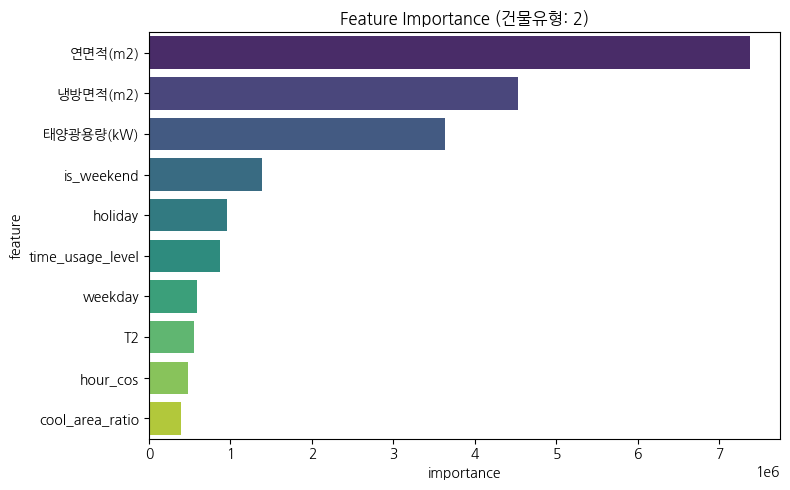


=== 건물유형: 3 ===
             feature    importance
25  time_usage_level  1.337595e+07
17         month_cos  4.446298e+06
6               hour  8.155128e+05
4              month  7.743045e+05
16         month_sin  7.478492e+05
15          hour_cos  5.343706e+05
10                DI  3.673900e+05
20                T2  2.636928e+05
5                day  1.933196e+05
9            holiday  1.623656e+05


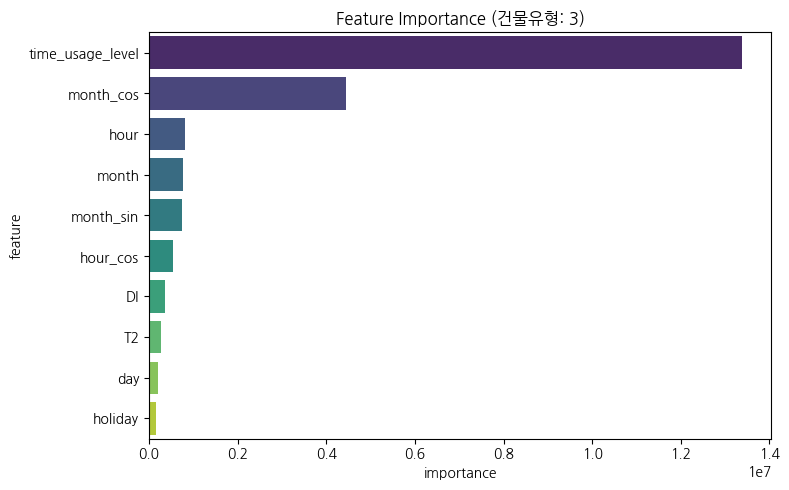


=== 건물유형: 4 ===
             feature    importance
37          btype_학교  1.765626e+07
26         month_cos  7.465530e+06
34        btype_건물기타  4.315888e+06
38  time_usage_level  2.669886e+06
10             month  2.458080e+06
14        is_weekend  1.871150e+06
25         month_sin  1.661288e+06
16     cdh_base_used  1.593082e+06
5            연면적(m2)  1.421005e+06
6           냉방면적(m2)  1.206368e+06


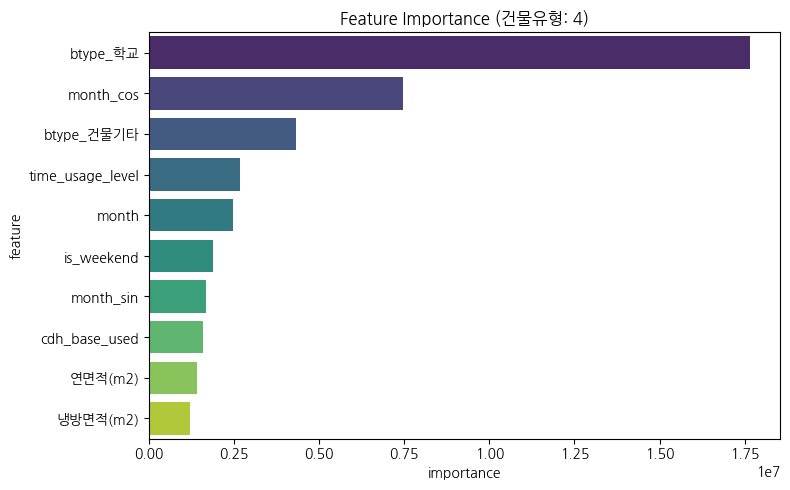


=== 건물유형: 5 ===
             feature    importance
30  time_usage_level  1.546226e+08
9               hour  9.727015e+06
20          hour_cos  4.246806e+06
5            연면적(m2)  2.828520e+06
19          hour_sin  2.609276e+06
6           냉방면적(m2)  2.309121e+06
22         month_cos  1.929379e+06
18      is_peak_hour  1.819221e+06
0               건물번호  1.129402e+06
14                DI  7.542053e+05


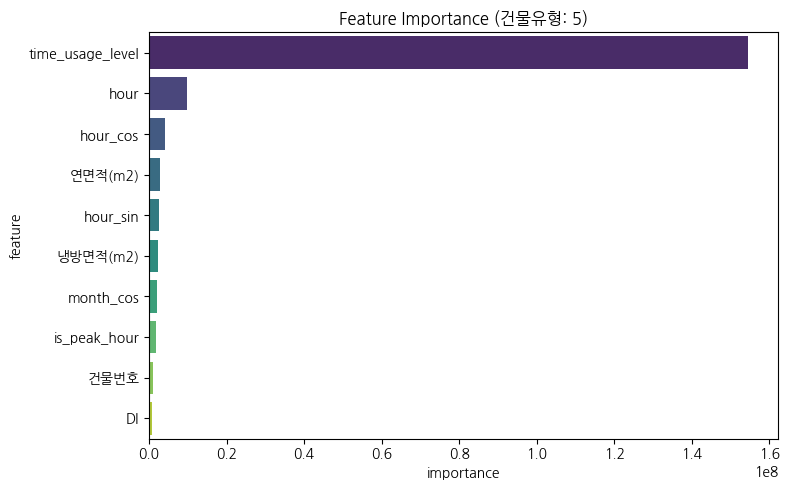


=== 건물유형: 6 ===
               feature     importance
28  cooling_load_index  232822.671875
5              연면적(m2)  181400.609375
13             holiday  124509.710938
12          is_weekend  109629.453125
25                 RH2  107961.304688
29    time_usage_level   86467.984375
11             weekday   83257.171875
14                  DI   75685.664062
23              T_x_RH   63868.339844
19            hour_cos   61327.156250


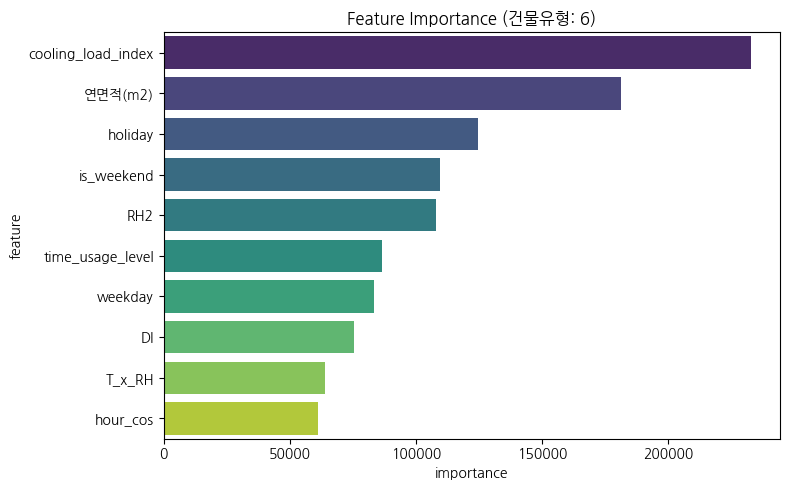


=== 건물유형: 7 ===
             feature    importance
25  time_usage_level  9.349095e+07
17         month_cos  2.244084e+07
6               hour  1.811346e+07
15          hour_cos  4.162726e+06
14          hour_sin  2.680426e+06
4              month  1.929781e+06
13      is_peak_hour  1.920021e+06
16         month_sin  1.117047e+06
10                DI  1.034061e+06
11               THI  7.703796e+05


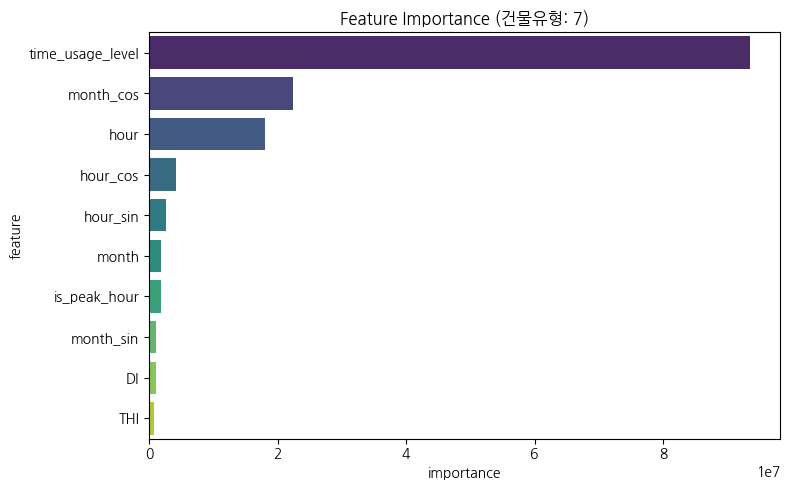


=== 건물유형: 8 ===
             feature    importance
26         month_cos  9.459328e+07
25         month_sin  2.353134e+07
10             month  2.252504e+07
5            연면적(m2)  8.151603e+06
6           냉방면적(m2)  4.870452e+06
0               건물번호  4.847284e+06
7          태양광용량(kW)  2.729838e+06
34  time_usage_level  2.219159e+06
12              hour  1.459929e+06
35   day_usage_level  1.376635e+06


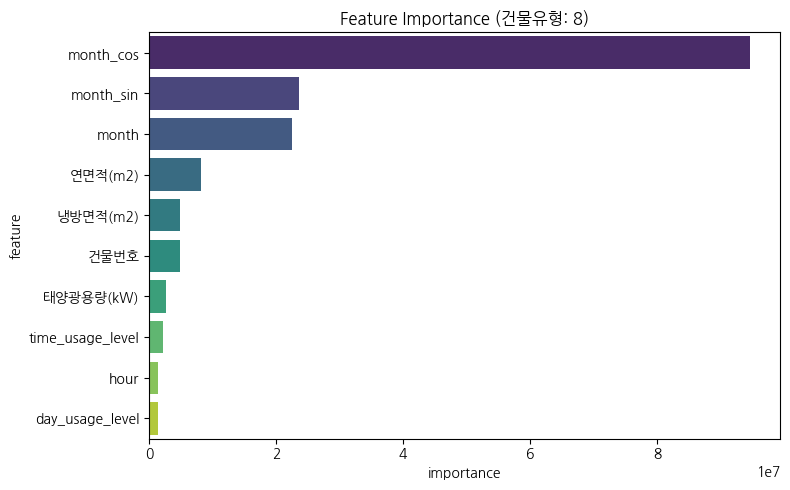


=== 건물유형: 9 ===
             feature   importance
15          hour_cos  26480038.00
25  time_usage_level  22966074.00
8         is_weekend  19767370.00
9            holiday   8310359.00
7            weekday   6806256.00
17         month_cos   6790447.00
26   day_usage_level   5073247.00
4              month   3442028.75
10                DI   2592675.00
16         month_sin   1733476.50


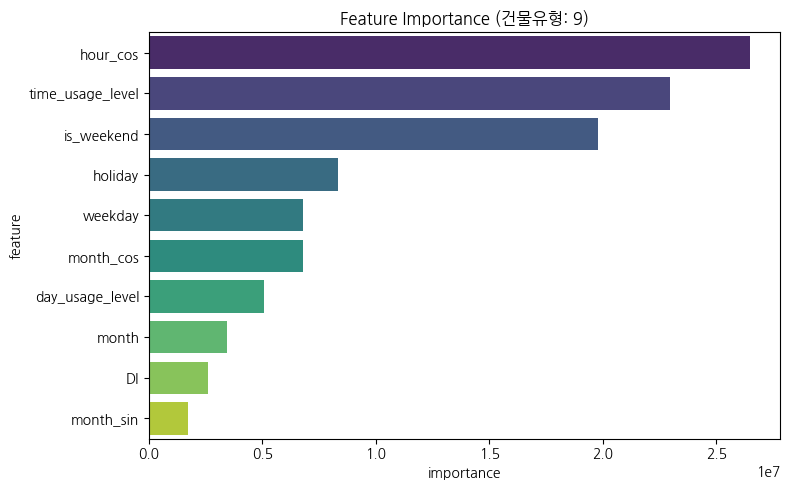


=== 건물유형: 10 ===
             feature    importance
8       ESS저장용량(kWh)  1.166338e+07
42  time_usage_level  3.539264e+06
21         ess_hours  2.729730e+06
6           냉방면적(m2)  2.268364e+06
16     cdh_base_used  1.215650e+06
36         btype_백화점  1.095660e+06
43   day_usage_level  9.125208e+05
38         btype_아파트  9.049463e+05
37          btype_상용  7.977173e+05
5            연면적(m2)  6.591791e+05


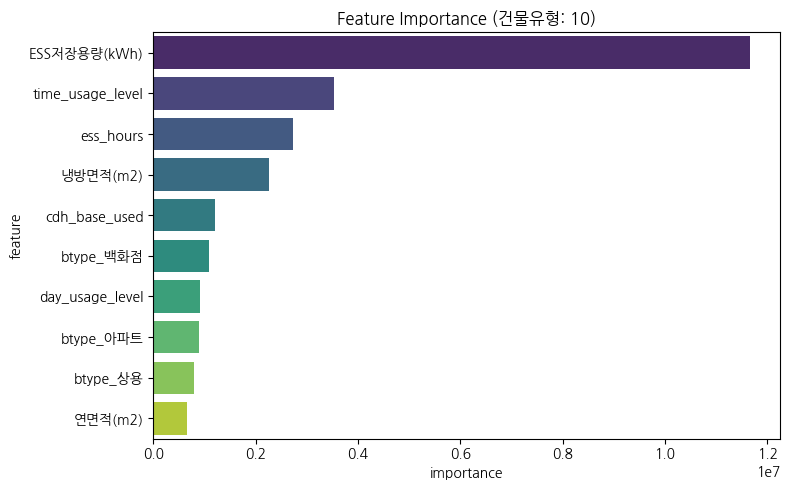


=== 건물유형: 11 ===
             feature   importance
41  time_usage_level  23299706.00
35         btype_백화점  20334796.00
34        btype_건물기타  13971750.00
39         btype_연구소   4846445.00
24          hour_cos   4005592.75
7          태양광용량(kW)   3914984.75
42   day_usage_level   3774184.50
37          btype_상용   3708031.00
26         month_cos   3285596.50
9          PCS용량(kW)   2157793.00


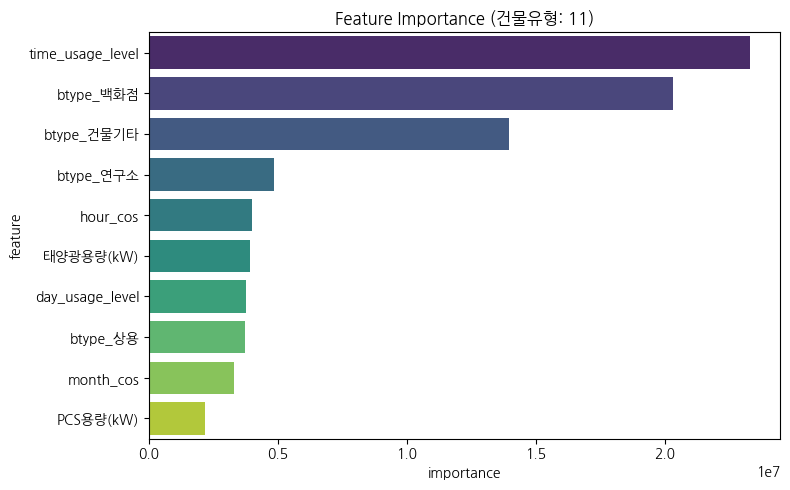

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

for btype, model in models.items():
    # feature importance 추출 (gain 기준)
    importance = model.get_booster().get_score(importance_type='gain')
    
    # dict → DataFrame 변환
    fi = pd.DataFrame({
        'feature': list(importance.keys()),
        'importance': list(importance.values())
    }).sort_values(by='importance', ascending=False)
    
    print(f"\n=== 건물유형: {btype} ===")
    print(fi.head(10))  # 상위 10개 feature 출력
    
    # 시각화
    plt.figure(figsize=(8,5))
    sns.barplot(data=fi.head(10), x='importance', y='feature', palette='viridis')
    plt.title(f"Feature Importance (건물유형: {btype})")
    plt.tight_layout()
    plt.show()


In [18]:
import pandas as pd

# 가중 중요도 집계용 딕셔너리
all_importances = {}

for btype, model in models.items():
    # 건물유형별 feature importance (gain 기준)
    importance = model.get_booster().get_score(importance_type='gain')
    
    # 가중치 = 해당 건물유형 샘플 수
    weight = len(train[train['건물유형']==btype])
    
    for feat, val in importance.items():
        if feat not in all_importances:
            all_importances[feat] = 0
        all_importances[feat] += val * weight   # 가중합

# DataFrame 변환
fi_all = pd.DataFrame(list(all_importances.items()), columns=['feature','weighted_importance'])

# 정규화 (0~1 사이로)
fi_all['weighted_importance'] /= fi_all['weighted_importance'].sum()

# 중요도 순 정렬
fi_all = fi_all.sort_values(by='weighted_importance', ascending=False).reset_index(drop=True)

print(fi_all.head(20))  # 상위 20개 출력


          feature  weighted_importance
0            건물번호                  NaN
1          기온(°C)                  NaN
2         강수량(mm)                  NaN
3         풍속(m/s)                  NaN
4           습도(%)                  NaN
5         연면적(m2)                  NaN
6        냉방면적(m2)                  NaN
7       태양광용량(kW)                  NaN
8    ESS저장용량(kWh)                  NaN
9       PCS용량(kW)                  NaN
10          month                  NaN
11            day                  NaN
12           hour                  NaN
13        weekday                  NaN
14     is_weekend                  NaN
15        holiday                  NaN
16  cdh_base_used                  NaN
17             DI                  NaN
18            THI                  NaN
19            CDH                  NaN


In [19]:
threshold = fi_all['weighted_importance'].quantile(0.15)  # 하위 15% 컷
low_importance_feats = fi_all[fi_all['weighted_importance'] <= threshold]['feature'].tolist()

print("제거 대상 feature:", low_importance_feats)

제거 대상 feature: []
